In [108]:
import os
# start the notebook in the root of the git repo, so that we can import our stuff
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

from src.simulation.sim import *
from src.simulation.initsim import gen_prior_param, init_simulation
from src.cli.simulations import first_k_with_value_then_random, flist_to_str
from src.simulation.graphs import gen_bba_graph, get_edge_generator, gen_complete_graph, friendliness_mat


In [143]:
n = 100
bias = 0.6           # theta0
partisan_mean = 0.6  # thetap
partisan_sd = 0.01

num_partisans = 0
disruption = num_partisans
max_steps = 10000
num_coins = 1
true_bias = bias
learning_rate = 0.25

frac_partisans = num_partisans / n
prior_mean = first_k_with_value_then_random(partisan_mean, num_partisans)
prior_sd = first_k_with_value_then_random(partisan_sd, num_partisans)

prior_mean = flist_to_str(gen_prior_param(prior_mean, n, range=(0,1)))
prior_sd = flist_to_str(gen_prior_param(prior_sd, n, range=(0.2, 0.8)))

sim_params = {
    "prior": {
        "mean": prior_mean,
        "sd": prior_sd,
        "n": n,
        "mean_range": (0,1),
        "sd_range": (0.2, 0.8),
    },
    "max_steps": max_steps,
    "true_bias": bias,
    "tosses_per_iteration": 1,
    "learning_rate": learning_rate,
    "asymptotic_learning_max_iters": 99,
    "DWeps": 1,
    "disruption": num_partisans,
    "log": True,  # need to log to get mean_list
    "coinslist": None,  # coin list needs to be None to have different simulations
    "break_on_asymptotic_learning": True,
}



In [145]:
complete = gen_complete_graph(n, get_edge_generator("enemies"))
bba = gen_bba_graph(n, 3, get_edge_generator("enemies"))

In [111]:
from collections import namedtuple
Step = namedtuple('Step', "step likelihood posterior_distr avg_dist_belief next_prior_distr")

In [112]:
import pandas as pd

In [113]:
def run_sim(g, asymptotic_learning_max_iters=99, **kwargs):

    rows = []

    prior_distr = init_simulation(g, prior=sim_params['prior'])
    friendliness = friendliness_mat(g)

    iters_asymptotic_learning = 0
    # steps 2-3 of Probabilistic automaton, until t = T
    for step in range(max_steps):

        # simulate an independent coin toss
        coins = toss_coins(bias=true_bias, num_coins=num_coins)

        # update the opinions of each agent according to Bayes' Theorem (observe coin toss)
        likelihood = coin_toss_likelihood(num_heads=coins, num_coins=num_coins)  # (eqn 2)

        posterior_distr = normalize_distr(likelihood * prior_distr)  # (eqn 1)

        # Rows: node i's posterior distribution.  Cols: posterior distr evaluated at theta
        # Need to change partisan's belief after cointoss before blending
        posterior_distr[:disruption] = prior_distr[:disruption]

        # Mix the opinions of each node with respective neighbours (eq 3,4)
        avg_dist_belief = avg_dist_in_belief(friendliness, posterior_distr)   # (eqn 4)

        bayes_update_max_RHS = posterior_distr + avg_dist_belief * learning_rate

        bayes_update_max_LHS = np.broadcast_to(EPSILON, (n, 21))
        bayes_update = np.amax(np.array([bayes_update_max_LHS, bayes_update_max_RHS]), axis=0)

        next_prior_distr = normalize_distr(bayes_update)
        next_prior_distr[:disruption] = prior_distr[:disruption]

        rows.append(Step(step, likelihood, posterior_distr, avg_dist_belief, next_prior_distr))

        posterior_distr = next_prior_distr

        # system reaches asymptotic learning when all agents reach asymptotic learning   
        largest_change = np.max(np.abs(posterior_distr - prior_distr), axis=1)
        largest_peak = 0.01 * np.max(prior_distr, axis=1)
        agent_is_asymptotic = largest_change < largest_peak  # one element for each agent

        # for the whole system...
        all_is_asymptotic = np.all(agent_is_asymptotic)
        if all_is_asymptotic:
            iters_asymptotic_learning += 1
        else:
            iters_asymptotic_learning = 0
    
        if iters_asymptotic_learning == asymptotic_learning_max_iters:
            break

        prior_distr = next_prior_distr

    return rows

In [114]:
import matplotlib.pyplot as plt

In [146]:
sim = pd.DataFrame(run_sim(complete))

In [147]:
sim_bba = pd.DataFrame(run_sim(bba))

In [148]:
sim_bba

,step,likelihood,posterior_distr,avg_dist_belief,next_prior_distr
0,0,"[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.64999...","[[0.0571481147498779, 0.06970757997168743, 0.0...","[[-0.0143138627133273, -0.0032383740356130356,...","[[0.05340309210461228, 0.06868377114026523, 0...."
1,1,"[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[[0.0, 0.012189657705714549, 0.029456824429982...","[[0.0, -0.0011856829669165119, 0.0029175865877...","[[0.0, 0.01156067487439554, 0.0293421453397124..."
2,2,"[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[[0.0, 0.0015548333575593554, 0.00789264413232...","[[0.0, -0.00020229148162288259, 0.001065207842...","[[0.0, 0.001418642757674988, 0.007694564793670..."
3,3,"[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[[0.0, 0.00017014923344849098, 0.0018457420577...","[[0.0, -4.713617672695736e-05, 0.0001936547636...","[[0.0, 0.0001433894245407035, 0.00171503538148..."
4,4,"[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.64999...","[[0.0, 0.0002472307499063938, 0.00280141437322...","[[0.0, -0.0001412366098007907, 3.2886345972729...","[[0.0, 0.00019678151876679928, 0.0026089102666..."
...,...,...,...,...,...
1686,1686,"[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.64999...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 0.0, -4.5742512188915194e-285, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
1687,1687,"[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 0.0, -1.9603933795249374e-285, -9....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
1688,1688,"[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 0.0, -8.401685912249731e-286, -5.5...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
1689,1689,"[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 0.0, -3.6007225338213135e-286, -3....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."


In [149]:
sim

,step,likelihood,posterior_distr,avg_dist_belief,next_prior_distr
0,0,"[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[[0.0, 0.006448781065303735, 0.015887345415316...","[[0.0, 0.001894939589118415, 0.006208247021704...","[[0.0, 0.006796591576855166, 0.017122174729920..."
1,1,"[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.64999...","[[0.0, 0.011782943124843914, 0.028121626594036...","[[0.0, 0.001210187507037002, 0.006787629568029...","[[0.0, 0.011827965514199575, 0.029183143722275..."
2,2,"[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[[0.0, 0.0015596328572130063, 0.00769616545996...","[[0.0, 0.00026142826118638894, 0.0025117205495...","[[0.0, 0.0015318875839674916, 0.00784717401426..."
3,3,"[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[[0.0, 0.00018016902089190901, 0.0018458504053...","[[0.0, 3.6005232423947125e-05, 0.0007097269791...","[[0.0, 0.0001736094808396886, 0.00185685020236..."
4,4,"[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.64999...","[[0.0, 0.00030291817009806297, 0.0030693588031...","[[0.0, 1.1881542455423698e-05, 0.0009025683246...","[[0.0, 0.0002842082024092415, 0.00306146229000..."
...,...,...,...,...,...
246,246,"[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, -3.7113963644957053e-101, -6.7194932237...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
247,247,"[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, -6.185660615094334e-102, -2.23983107732...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
248,248,"[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.64999...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, -8.394825116800801e-102, -2.87978281243...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
249,249,"[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.64999...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, -1.1392976938872342e-101, -3.7025778999...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."


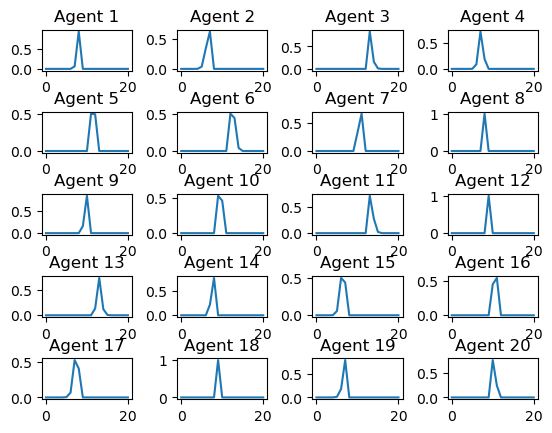

In [163]:
plt.subplots(5, 4)
plt.subplots_adjust(hspace=1, wspace=0.5)

for i in range(5):
    for j in range(4):
        k = i*4+j+1
        plt.subplot(5, 4, k)
        plt.plot(sim.posterior_distr[50][k-1].round(3))
        plt.title(f"Agent {k}")

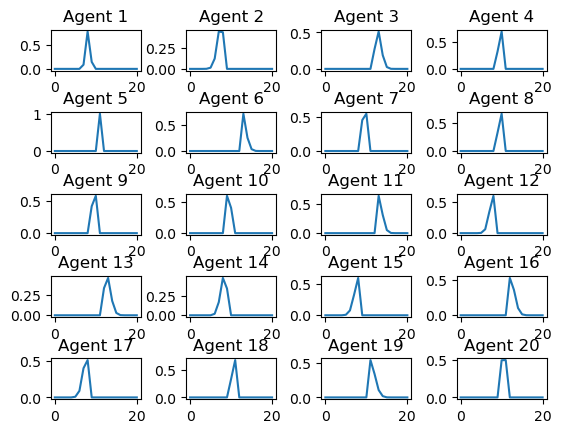

: 

In [166]:
plt.subplots(5, 4)
plt.subplots_adjust(hspace=1, wspace=0.5)

for i in range(5):
    for j in range(4):
        k = i*4+j+1
        plt.subplot(5, 4, k)
        plt.plot(sim_bba.next_prior_distr[40][k-1].round(3))
        plt.title(f"Agent {k}")


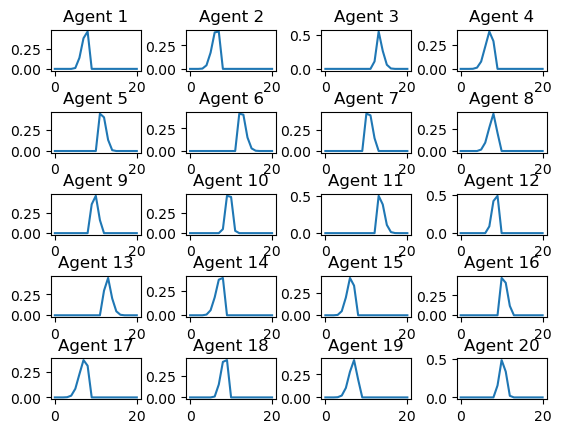

In [152]:
plt.subplots(5, 4)
plt.subplots_adjust(hspace=1, wspace=0.5)

for i in range(5):
    for j in range(4):
        k = i*4+j+1
        plt.subplot(5, 4, k)
        plt.plot(sim.next_prior_distr[25][k-1].round(3))
        plt.title(f"Agent {k}")


In [119]:
sim.likelihood[10]

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [120]:
sim.likelihood

0      [0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...
1      [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.64999...
2      [0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...
3      [0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...
4      [0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...
                             ...                        
411    [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.64999...
412    [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.64999...
413    [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.64999...
414    [0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...
415    [0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...
Name: likelihood, Length: 416, dtype: object

In [121]:
sim.next_prior_distr[10]

array([[0.00000000e+00, 6.51994616e-07, 7.65768401e-05, 1.13100382e-03,
        6.90297620e-03, 2.52289896e-02, 6.47725807e-02, 1.26448730e-01,
        1.96185126e-01, 2.43161547e-01, 2.25259012e-01, 1.10832806e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.09396106e-02, 1.05305340e-01,
        1.62443745e-01, 1.94052695e-01, 1.90476564e-01, 1.53836606e-01,
        9.96106634e-02, 4.79832575e-02, 1.40710634e-02, 1.28045579e-03,
        0.00000000e+00],
       [0.00000000e+00, 4.70688419e-06, 4.52015886e-04, 5.47590289e-03,
        2.73417145e-02, 8.10675561e-02, 1.66094877e-01, 2.50213292e-01,
        2.76754460e-01, 1.92595475e-01, 0.00000000e+00, 0.00000000e+00,
        0.0000

In [122]:
sim.posterior_distr[10].round(3)

array([[0.   , 0.   , 0.   , 0.001, 0.007, 0.025, 0.063, 0.123, 0.191,
        0.239, 0.226, 0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.046, 0.112, 0.161, 0.189, 0.184, 0.149, 0.097, 0.047,
        0.014, 0.001, 0.   ],
       [0.   , 0.   , 0.   , 0.005, 0.027, 0.079, 0.163, 0.247, 0.277,
        0.201, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.051, 0.113, 0.157, 0.183, 0.18 , 0.148, 0.1  , 0.05 ,
        0.015, 0.001, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.012, 0.044,
        0.097, 0.158, 0.197, 0.192, 0.154, 0.097, 0.042, 0.006, 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.003, 0.012, 0.036, 0.082, 0.146,
        0.21 , 0.239, 0.195, 0.078, 0.   , 0.   , 0.   , 0.   , 0.   

In [123]:
sim.avg_dist_belief[10]

array([[ 0.00000000e+00,  3.88371201e-07,  4.94798474e-05,
         7.69683191e-04,  4.87416304e-03,  1.82215799e-02,
         4.73937325e-02,  9.20556543e-02,  1.40074382e-01,
         1.67180662e-01,  1.36640043e-01,  1.10857900e-02,
        -1.28078914e-01, -1.35036738e-01, -1.29751712e-01,
        -1.06626459e-01, -7.16949704e-02, -3.56016897e-02,
        -1.06017910e-02, -9.53284244e-04,  0.00000000e+00],
       [ 0.00000000e+00, -3.01830176e-07, -3.05671163e-05,
        -4.02338727e-04, -2.23272287e-03, -7.64542319e-03,
        -1.88558538e-02, -3.73991546e-02, -6.14983353e-02,
        -8.43518091e-02, -5.29419210e-02, -3.13801132e-03,
         4.11626745e-02,  6.33939939e-02,  6.44396079e-02,
         5.05923570e-02,  3.06584823e-02,  1.39248010e-02,
         3.95549459e-03,  3.69027701e-04,  0.00000000e+00],
       [ 0.00000000e+00,  4.50737024e-06,  4.31603972e-04,
         5.20326262e-03,  2.58032149e-02,  7.56941248e-02,
         1.52558893e-01,  2.22701950e-01,  2.30386965e

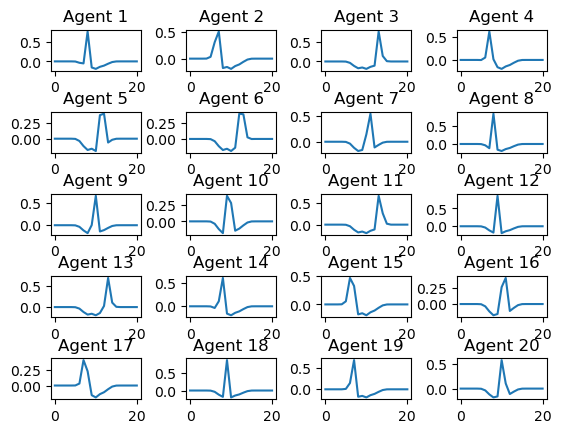

In [161]:
plt.subplots(5, 4)
plt.subplots_adjust(hspace=1, wspace=0.5)

for i in range(5):
    for j in range(4):
        k = i*4+j+1
        plt.subplot(5, 4, k)
        plt.plot(sim.avg_dist_belief[50][k-1].round(3))
        plt.title(f"Agent {k}")



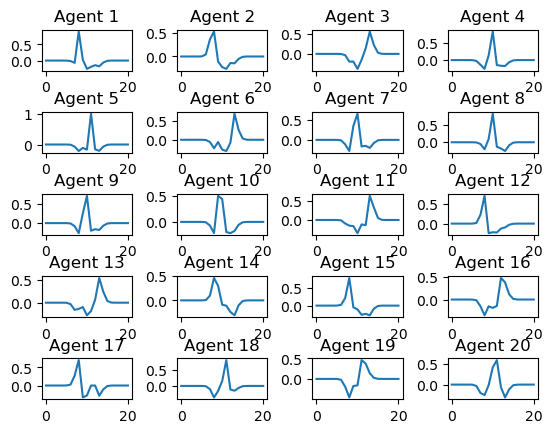

In [162]:
plt.subplots(5, 4)
plt.subplots_adjust(hspace=1, wspace=0.5)

for i in range(5):
    for j in range(4):
        k = i*4+j+1
        plt.subplot(5, 4, k)
        plt.plot(sim_bba.avg_dist_belief[50][k-1].round(3))
        plt.title(f"Agent {k}")


In [91]:
sim.avg_dist_belief[250].round(3)

array([[ 0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
        -0.   , -0.   , -0.105, -0.053, -0.158,  0.842, -0.158, -0.211,
        -0.158, -0.   , -0.   , -0.   ,  0.   ],
       [ 0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
        -0.   , -0.   , -0.105, -0.053, -0.158, -0.211,  0.895, -0.211,
        -0.158, -0.   , -0.   , -0.   ,  0.   ],
       [ 0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
        -0.   , -0.   , -0.105, -0.053, -0.158, -0.211, -0.158, -0.211,
         0.895,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.008,  0.939, -0.053, -0.158, -0.211, -0.158, -0.211,
        -0.158, -0.   , -0.   , -0.   ,  0.   ],
       [ 0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
        -0.   , -0.   , -0.105, -0.053, -0.158,  0.842, -0.158, -0.211,
        -0.158, -0.   , -0.   , -0.   ,  0.   ],
       [ 0.   , -0.   , -0.   , -0.